# AMQ Structures for Status List

First, we need an AMQ implementation that is somewhat safe. Bloomfilters seem to be our best bet. To be super-safe, they need to use only cryptographic hash functions.

## Setup

In [11]:
from rbloom import Bloom
from hashlib import sha256
from pickle import dumps
import uuid
import time
import matplotlib.pyplot as plt
import math


def hash_func(obj):
    h = sha256(dumps(obj)).digest()
    return int.from_bytes(h[:16], "big") - 2 ** 127


def new_bloom(size, fpr):
    return Bloom(size, fpr, hash_func)


class FilterCascade:
    def __init__(self, positives, negatives):
        self.filters = []
        self.__help_build_cascade(positives, negatives)

    def __help_build_cascade(self, positives, negatives):
        bloom = new_bloom(len(positives), 0.01)
        for elem in positives:
            bloom.add(elem)
        fps = []
        for elem in negatives:
            if elem in bloom:
                fps.append(elem)
        self.filters.append(bloom)
        if len(fps) == 0:
            return
        self.__help_build_cascade(fps, positives)

    def __contains__(self, entry):
        for i in range(len(self.filters)):
            if entry not in self.filters[i]:
                return i % 2 == 1
        return (len(self.filters) - 1) % 2 == 0

    def size_in_bits(self):
        size = 0
        for bf in self.filters:
            size = size + bf.size_in_bits
        return size
    
def plot_data(x_series, y_series, x_label, y_label, label):
    plt.plot(x_series, y_series, marker='o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(label)
    plt.grid(True)
    plt.show()


## Sanity check

In [12]:
def sanity_check():
    positives = []
    for i in range(10_000):
        positives.append(uuid.uuid4())
    negatives = []
    for i in range(1_000_000):
        negatives.append(uuid.uuid4())
    start_time = time.time()
    test_cascade = FilterCascade(positives, negatives)
    elapsed_time = time.time() - start_time
    print(f"Cascade build time: {elapsed_time:.2f} seconds")
    print(f"Cascade size: {test_cascade.size_in_bits()/8.0}B")
    for elem in negatives:
        assert elem not in test_cascade
    for elem in positives:
        assert elem in test_cascade

## How fast is the cascade for different sizes?
Plotting it.

Cascade build time: 0.00 seconds
Cascade size: 2.0B
Cascade build time: 0.00 seconds
Cascade size: 14.0B
Cascade build time: 0.00 seconds
Cascade size: 134.0B
Cascade build time: 0.04 seconds
Cascade size: 1323.0B
Cascade build time: 0.38 seconds
Cascade size: 13251.0B
Cascade build time: 4.03 seconds
Cascade size: 132094.0B
Cascade build time: 39.38 seconds
Cascade size: 1320765.0B
Cascade build time: 1199.51 seconds
Cascade size: 13210484.0B


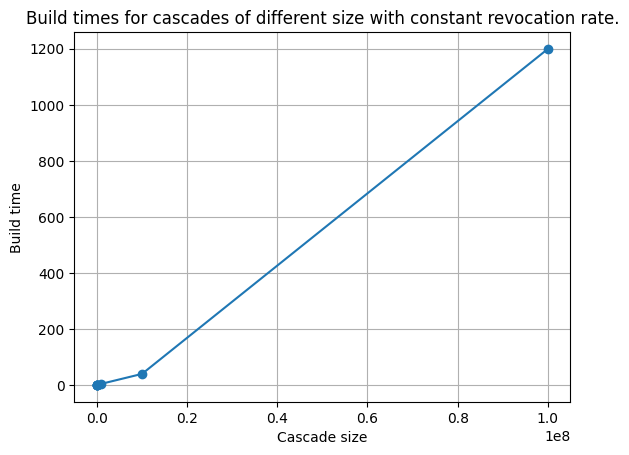

In [13]:
def time_log_cascade_sizes(start, end, revocation_rate):
    n = start
    sizes = []
    times = []
    while n <= end:
        revoked = []
        for i in range(math.floor(revocation_rate*n)):
            revoked.append(uuid.uuid4())
        valid = []
        for i in range(math.floor((1.0-revocation_rate)*n)):
            valid.append(uuid.uuid4())
        start_time = time.time()
        test_cascade = FilterCascade(revoked, valid)
        elapsed_time = time.time() - start_time
        sizes.append(n)
        times.append(elapsed_time)
        n = n*10
        print(f"Cascade build time: {elapsed_time:.2f} seconds")
        print(f"Cascade size: {test_cascade.size_in_bits()/8.0}B")
    plot_data(sizes, times, "Cascade size", "Build time", "Build times for cascades of different size with constant revocation rate.")

time_log_cascade_sizes(10, 100_000_000, 0.1)

## How does the cascades first layer size and cascade depth correlate to size of revoked or unrevoked entries?
Plotting it.